In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pylab as pltlab
import pydicom
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

In [2]:
# load CSV's
csv_train_file = pd.read_csv('/home/malmason/datasets/siim-isic-melanoma-classification/train.csv')

In [3]:
csv_train_file = csv_train_file.sample(frac=1).reset_index(drop=True)

In [4]:
# Point to image folders
img_train_folder = '/home/malmason/datasets/siim-isic-melanoma-classification/ycbcr/norm/train/'

In [5]:
# Used for looping through image columns
X_train_img = csv_train_file['image_name']

In [6]:
csv_train_file.head(2)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_7612324,IP_2976930,female,30.0,torso,nevus,benign,0
1,ISIC_3257327,IP_9738076,female,70.0,torso,unknown,benign,0


In [7]:
print(f"Train set size: {len(csv_train_file)}, \tUnique patients: {len(csv_train_file['patient_id'].value_counts())}")

Train set size: 33126, 	Unique patients: 2056


In [8]:
# Fill missing values
csv_train_file["anatom_site_general_challenge"].fillna("Unknown", inplace = True)
csv_train_file["sex"].fillna("Unknown", inplace = True)

In [9]:
head_neck = csv_train_file.loc[csv_train_file['anatom_site_general_challenge'] == 'head/neck']
upper_extremity = csv_train_file.loc[csv_train_file['anatom_site_general_challenge'] == 'upper extremity']
lower_extremity = csv_train_file.loc[csv_train_file['anatom_site_general_challenge'] == 'lower extremity']
oral_genital = csv_train_file.loc[csv_train_file['anatom_site_general_challenge'] == 'oral/genital']
palms_soles = csv_train_file.loc[csv_train_file['anatom_site_general_challenge'] == 'palms/soles']
torso = csv_train_file.loc[csv_train_file['anatom_site_general_challenge'] == 'torso']
none = csv_train_file.loc[csv_train_file['anatom_site_general_challenge'] == 'Unknown']

zero, one = csv_train_file['target'].value_counts()
print(f'\nTotal train set: {zero+one}\tNormal: {zero}\tMelanoma: {one}\tPercent: {np.round(one / zero,4)*100}%')

print("\nTrain set breakdown\n-------------------")
zero , one = head_neck.groupby('target').target.count()
print(f"Head neck melanoma\tTotal: {zero+one}\tNormal: {zero}\tMelanoma: {one}\tPercent: {np.round(100*(one / zero),2)}%")
zero , one = lower_extremity.groupby('target').target.count()
print(f"lower_extremity   \tTotal: {zero+one}\tNormal: {zero}\tMelanoma: {one}\tPercent: {np.round(100*(one / zero),2)}%")
zero , one = oral_genital.groupby('target').target.count()
print(f"oral_genital      \tTotal: {zero+one}\tNormal: {zero}\tMelanoma: {one}\tPercent: {np.round(100*(one / zero),2)}%")
zero , one = palms_soles.groupby('target').target.count()
print(f"palms_soles       \tTotal: {zero+one}\tNormal: {zero}\tMelanoma: {one}\tPercent: {np.round(100*(one / zero),2)}%")
zero , one = torso.groupby('target').target.count()
print(f"torso             \tTotal: {zero+one}\tNormal: {zero}\tMelanoma: {one}\tPercent: {np.round(100*(one / zero),2)}%")
zero , one = upper_extremity.groupby('target').target.count()
print(f"upper_extremity   \tTotal: {zero+one}\tNormal: {zero}\tMelanoma: {one}\tPercent: {np.round(100*(one / zero),2)}%")
zero , one =  none.groupby('target').target.count()
print(f"Unknown           \tTotal: {zero+one}\tNormal: {zero}\tMelanoma: {one}\tPercent: {np.round(100*(one / zero),2)}%")
print(f"\nNull values for location: {csv_train_file['anatom_site_general_challenge'].isnull().sum()}")

# User to order 0 to 1 for anatom_site_general_challenge categorization


Total train set: 33126	Normal: 32542	Melanoma: 584	Percent: 1.79%

Train set breakdown
-------------------
Head neck melanoma	Total: 1855	Normal: 1781	Melanoma: 74	Percent: 4.15%
lower_extremity   	Total: 8417	Normal: 8293	Melanoma: 124	Percent: 1.5%
oral_genital      	Total: 124	Normal: 120	Melanoma: 4	Percent: 3.33%
palms_soles       	Total: 375	Normal: 370	Melanoma: 5	Percent: 1.35%
torso             	Total: 16845	Normal: 16588	Melanoma: 257	Percent: 1.55%
upper_extremity   	Total: 4983	Normal: 4872	Melanoma: 111	Percent: 2.28%
Unknown           	Total: 527	Normal: 518	Melanoma: 9	Percent: 1.74%

Null values for location: 0


In [10]:
age_range = csv_train_file['age_approx'].dropna().unique()
age_range.sort()
for some_var in age_range:
    age = csv_train_file.loc[csv_train_file['age_approx'] == some_var]
    try:
        zero , one =  age.groupby('target').target.count()
        print(f"Age approx:  {some_var}\tNormal: {zero}\tMelanoma: {one}\tPercent: {np.round(100*(one / zero),2)}%")
    except:
        print(f'{some_var} is missing either 0 or 1')
# Ages classified 0 to 1 in order of age, as older more likely to gain skin cancer

0.0 is missing either 0 or 1
10.0 is missing either 0 or 1
Age approx:  15.0	Normal: 130	Melanoma: 2	Percent: 1.54%
Age approx:  20.0	Normal: 649	Melanoma: 6	Percent: 0.92%
Age approx:  25.0	Normal: 1528	Melanoma: 16	Percent: 1.05%
Age approx:  30.0	Normal: 2334	Melanoma: 24	Percent: 1.03%
Age approx:  35.0	Normal: 2825	Melanoma: 25	Percent: 0.88%
Age approx:  40.0	Normal: 3552	Melanoma: 24	Percent: 0.68%
Age approx:  45.0	Normal: 4412	Melanoma: 54	Percent: 1.22%
Age approx:  50.0	Normal: 4217	Melanoma: 53	Percent: 1.26%
Age approx:  55.0	Normal: 3760	Melanoma: 64	Percent: 1.7%
Age approx:  60.0	Normal: 3175	Melanoma: 65	Percent: 2.05%
Age approx:  65.0	Normal: 2457	Melanoma: 70	Percent: 2.85%
Age approx:  70.0	Normal: 1910	Melanoma: 58	Percent: 3.04%
Age approx:  75.0	Normal: 919	Melanoma: 62	Percent: 6.75%
Age approx:  80.0	Normal: 383	Melanoma: 36	Percent: 9.4%
Age approx:  85.0	Normal: 140	Melanoma: 9	Percent: 6.43%
Age approx:  90.0	Normal: 64	Melanoma: 16	Percent: 25.0%


In [11]:
male = csv_train_file.loc[csv_train_file['sex'] == 'male']
female = csv_train_file.loc[csv_train_file['sex'] == 'female']
unknown = csv_train_file.loc[csv_train_file['sex'] == 'Unknown']
zero , one = male.groupby('target').target.count()
print(f"male     \tTotal: {zero+one}\tNormal: {zero}\tMelanoma: {one}\tPercent: {np.round(100*(one / zero),2)}%")
zero , one = female.groupby('target').target.count()
print(f"female   \tTotal: {zero+one}\tNormal: {zero}\tMelanoma: {one}\tPercent: {np.round(100*(one / zero),2)}%")

try:
    zero , one =  unknown.groupby('target').target.count()
    print(f"unknown:  \tTotal: {zero+one}\tNormal: {zero}\tMelanoma: {one}\tPercent: {np.round(100*(one / zero),2)}%")
except:
    print(f'missing either 0 or 1')

male     	Total: 17080	Normal: 16716	Melanoma: 364	Percent: 2.18%
female   	Total: 15981	Normal: 15761	Melanoma: 220	Percent: 1.4%
missing either 0 or 1


In [12]:
# Grfeater risk has higher value
malignent_cat = {'benign':0, 'melanoma':1}
sex_cat = {'female':0, 'male':1, 'unknown':2}
localization_cat = {'palms/soles':0, 'lower extremity':1, 'torso':2, 'Unknown':3, 'upper extremity':4, 'oral/genital':5, 'head/neck':6}

age_cat = {0.0:0, 10.0:1, 40.0:2, 35.0:3, 20:4, 30.0:5, 25.0:6, 45.0:7, 50.0:8, 15.0:9, 55.0:10,
                            60.0:11, 65.0:12, 70.0:13, 85.0:14, 75.0:15, 80.0:16, 90.0:17}

csv_train_file.benign_malignant = csv_train_file.benign_malignant.map(malignent_cat).astype(float)
csv_train_file.sex = csv_train_file.sex.map(sex_cat).astype(float)
csv_train_file.age_approx = csv_train_file.age_approx.map(age_cat).astype(float)
csv_train_file.anatom_site_general_challenge = csv_train_file.anatom_site_general_challenge.map(localization_cat).astype(float)

In [13]:
csv_train_file.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_7612324,IP_2976930,0.0,5.0,2.0,nevus,0.0,0
1,ISIC_3257327,IP_9738076,0.0,13.0,2.0,unknown,0.0,0
2,ISIC_4368478,IP_1362494,0.0,8.0,4.0,unknown,0.0,0
3,ISIC_0826834,IP_9644384,0.0,6.0,4.0,unknown,0.0,0
4,ISIC_6581765,IP_9362467,0.0,7.0,2.0,unknown,0.0,0


In [14]:
csv_train_file = csv_train_file.sort_values('target')

In [15]:
zer_value, one_value = csv_train_file.target.value_counts()

zer_value_num = int(zer_value*.8)
one_value_num = int(one_value*.8)
tot_value = len(csv_train_file)

csv_train_file_train = csv_train_file[:zer_value_num]
csv_train_file_train = csv_train_file_train.append(csv_train_file[zer_value:zer_value+one_value_num])

csv_train_file_val = csv_train_file[zer_value_num:zer_value]
csv_train_file_val = csv_train_file_val.append(csv_train_file[zer_value+one_value_num:])

zer_value_tr, one_value_tr = csv_train_file_train.target.value_counts()
zer_value_va, one_value_va = csv_train_file_val.target.value_counts()
print(f'Zero and one train: {zer_value_tr, one_value_tr}, Zero and one val: {zer_value_va, one_value_va}')

Zero and one train: (26033, 467), Zero and one val: (6509, 117)


In [16]:
csv_train_file_train = csv_train_file_train.append(csv_train_file_train.loc[csv_train_file_train['target'] == 1])
csv_train_file_train = csv_train_file_train.append(csv_train_file_train.loc[csv_train_file_train['target'] == 1])
csv_train_file_train = csv_train_file_train.append(csv_train_file_train.loc[csv_train_file_train['target'] == 1])
'''
csv_train_file_train = csv_train_file_train.append(csv_train_file_train.loc[csv_train_file_train['target'] == 1])
csv_train_file_train = csv_train_file_train.append(csv_train_file_train.loc[csv_train_file_train['target'] == 1])
csv_train_file_train = csv_train_file_train.append(csv_train_file_train.loc[csv_train_file_train['target'] == 1])
'''

"\ncsv_train_file_train = csv_train_file_train.append(csv_train_file_train.loc[csv_train_file_train['target'] == 1])\ncsv_train_file_train = csv_train_file_train.append(csv_train_file_train.loc[csv_train_file_train['target'] == 1])\ncsv_train_file_train = csv_train_file_train.append(csv_train_file_train.loc[csv_train_file_train['target'] == 1])\n"

In [17]:
zer_value_tr, one_value_tr = csv_train_file_train.target.value_counts()
zer_value_va, one_value_va = csv_train_file_val.target.value_counts()
print(f'Zero and one train: {zer_value_tr, one_value_tr}, Zero and one val: {zer_value_va, one_value_va}')

Zero and one train: (26033, 3736), Zero and one val: (6509, 117)


In [18]:
csv_train_file_train = csv_train_file_train.sample(frac=1).reset_index(drop=True)
csv_train_file_val = csv_train_file_val.sample(frac=1).reset_index(drop=True)

In [19]:
X_train_data = csv_train_file_train.drop(['image_name', 'patient_id', 'diagnosis', 'benign_malignant', 'target'], axis=1)
X_val_data = csv_train_file_val.drop(['image_name', 'patient_id', 'diagnosis', 'benign_malignant', 'target'], axis=1)
Y_train = csv_train_file_train['target']
Y_val = csv_train_file_val['target']

In [20]:
print(X_train_data.shape, Y_train.shape, X_val_data.shape, Y_val.shape)

(29769, 3) (29769,) (6626, 3) (6626,)


In [21]:
mean = X_train_data.mean(axis=0)
X_train_data -= mean
std = X_train_data.std(axis=0)
X_train_data /= std

mean = X_val_data.mean(axis=0)
X_val_data -= mean
std = X_val_data.std(axis=0)
X_val_data /= std

In [22]:
X_train_img = csv_train_file_train['image_name']
X_val_img = csv_train_file_val['image_name']

In [23]:
sizing = 224 - 2            # conv1
sizing = (sizing - 2) / 2   # conv2  
sizing = (sizing - 2)       # conv3
sizing = (sizing - 2) / 2   # conv4
sizing = (sizing - 2)       # conv5
sizing = (sizing - 2) / 2   # conv6
sizing = (sizing - 2)       # conv7
sizing = (sizing - 2) / 2   # conv8
sizing = (sizing - 2) /2    # conv9
print(512*(int(sizing)*int(sizing)))

8192


In [24]:
sizing = 224 - 4            # conv1
sizing = (sizing - 4) / 2   # conv2  
sizing = (sizing - 4) / 2   # conv4
sizing = (sizing - 4) / 2   # conv6
sizing = (sizing - 4) / 2   # conv8
sizing = (sizing - 4) / 2   # conv9
print(512*(int(sizing)*int(sizing)))

4608


In [25]:
class CNN(nn.Module):
  def __init__(self, n_output_neurons):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(3 , 32,   kernel_size=3, stride=1)
    self.conv2 = nn.Conv2d(32, 32,   kernel_size=3, stride=1)
    self.bn1   = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32 , 64,  kernel_size=3, stride=1)
    self.conv4 = nn.Conv2d(64 , 64,  kernel_size=3, stride=1)
    self.bn2   = nn.BatchNorm2d(64)
    self.conv5 = nn.Conv2d(64 , 128, kernel_size=3, stride=1)
    self.conv6 = nn.Conv2d(128 ,128, kernel_size=3, stride=1)
    self.bn3   = nn.BatchNorm2d(128)
    self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
    self.conv8 = nn.Conv2d(256 ,256, kernel_size=3, stride=1)
    self.bn4   = nn.BatchNorm2d(256)
    self.conv9 = nn.Conv2d(256, 512, kernel_size=3, stride=1)
    self.bn5   = nn.BatchNorm2d(512)

    self.conv11 = nn.Conv2d(3 , 32,   kernel_size=5, stride=1)
    self.bn11   = nn.BatchNorm2d(32)
    self.conv21 = nn.Conv2d(32 , 64,  kernel_size=5, stride=1)
    self.bn21   = nn.BatchNorm2d(64)
    self.conv31 = nn.Conv2d(64 , 128, kernel_size=5, stride=1)
    self.bn31   = nn.BatchNorm2d(128)
    self.conv41 = nn.Conv2d(128, 256, kernel_size=5, stride=1)
    self.bn41   = nn.BatchNorm2d(256)
    self.conv51 = nn.Conv2d(256, 512, kernel_size=5, stride=1)
    
    self.fc1   = nn.Linear(8192+4608,128)
    self.fc2   = nn.Linear(128,16)
    self.fc3   = nn.Linear(16, n_output_neurons)

  def forward(self, x):
    xa = F.relu(self.conv1(x),2)
    xa = F.relu(F.max_pool2d(self.conv2(xa),2))
    xa = self.bn1(xa)
    xa = F.relu(self.conv3(xa),2)
    xa = F.relu(F.max_pool2d(self.conv4(xa),2))
    xa = self.bn2(xa)
    xa = F.relu(self.conv5(xa),2)
    xa = F.relu(F.max_pool2d(self.conv6(xa),2))
    xa = self.bn3(xa)
    xa = F.relu(self.conv7(xa),2)
    xa = F.relu(F.max_pool2d(self.conv8(xa),2))
    xa = self.bn4(xa)
    xa = F.relu(F.max_pool2d(self.conv9(xa),2))
    xa = self.bn5(xa)

    xb = F.relu(F.max_pool2d(self.conv11(x),2))
    xb = self.bn11(xb)
    xb = F.relu(F.max_pool2d(self.conv21(xb),2))
    xb = self.bn21(xb)
    xb = F.relu(F.max_pool2d(self.conv31(xb),2))
    xb = self.bn31(xb)
    xb = F.relu(F.max_pool2d(self.conv41(xb),2))
    xb = self.bn41(xb)
    xb = F.relu(F.max_pool2d(self.conv51(xb),2))
    xb = self.bn5(xb)
    
    xa = xa.view(xa.size(0), -1)
    xb = xb.view(xb.size(0), -1)
    
    x = torch.cat((xa, xb), dim=1)
    
    
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.3)
    x = F.relu(self.fc2(x))
    x = F.dropout(x, p=0.2)
    x = self.fc3(x)

    return x

In [26]:
n_channels = 3
n_output_neurons = 1

In [27]:
model = CNN(n_output_neurons)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [29]:
csv_train_file.head(2)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_7612324,IP_2976930,0.0,5.0,2.0,nevus,0.0,0
21988,ISIC_8405944,IP_4865295,1.0,11.0,2.0,unknown,0.0,0


In [30]:
X_train_image = []
for image_get in X_train_img:
    img_train = cv2.imread(img_train_folder + '{}.jpg'.format(image_get))
    '''
    rand_num = np.random.uniform(low=1, high=1.2)
    M = cv2.resize(img_train, None, fx= rand_num, fy= rand_num, interpolation= cv2.INTER_LINEAR)
    
    H_crop = ((224*rand_num)-224)/2
    V_crop = ((224*rand_num)-224)/2
    
    C = M[np.int(H_crop):np.int(M.shape[0]-H_crop),np.int(V_crop):np.int(M.shape[1]-np.int(V_crop))]
    img_train= cv2.resize(C,(224,224))
    '''
    X_train_image.append(img_train)

In [31]:
X_val_image = []
for image_get in X_val_img:
    img_val = cv2.imread(img_train_folder + '{}.jpg'.format(image_get))
    
    X_val_image.append(img_val)

In [32]:
X_train_image = np.array(X_train_image)
X_train_image = X_train_image.astype(np.float32)
X_val_image = np.array(X_val_image)
X_val_image = X_val_image.astype(np.float32)

In [33]:
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)

In [34]:
X_train_image = X_train_image / 255
X_val_image = X_val_image / 255

In [35]:
print(f'Train shape: {X_train_image.shape}, Vl shape: {X_val_image.shape}')

Train shape: (29769, 224, 224, 3), Vl shape: (6626, 224, 224, 3)


In [36]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [37]:
X_train_image_t = np.transpose(X_train_image, (0,3,1,2))

In [38]:
input_train = torch.from_numpy(X_train_image_t)
target_train = torch.from_numpy(Y_train).reshape(-1,1).float()

In [39]:
X_val_image_t = np.transpose(X_val_image, (0,3,1,2))

In [40]:
input_val = torch.from_numpy(X_val_image_t)
target_val = torch.from_numpy(Y_val).reshape(-1,1).float()

In [41]:
X_train_data_np = X_train_data.values
X_train_data_np = X_train_data_np.astype(np.float32)

In [42]:
input_train_data = torch.from_numpy(X_train_data_np)

In [43]:
X_val_data_np = X_val_data.values
X_val_data_np = X_val_data_np.astype(np.float32)

In [44]:
input_val_data = torch.from_numpy(X_val_data_np)

In [45]:
n_epochs = 4
train_losses = []
val_losses = []

In [46]:
batch_size = 64
training_set = torch.utils.data.TensorDataset(input_train, target_train)
train_loader = torch.utils.data.DataLoader(dataset=training_set, 
                                           batch_size=batch_size,
                                           num_workers=2,
                                           shuffle=True)
val_set = torch.utils.data.TensorDataset(input_val, target_val)
val_loader = torch.utils.data.DataLoader(dataset=val_set, 
                                           batch_size=batch_size,
                                         num_workers=2,
                                           shuffle=False)

In [47]:
def binary_acc(output_pred, target):
    output_pred_tag = torch.round(torch.sigmoid(output_pred))

    correct_results_sum = (output_pred_tag == target).sum().float()
    acc = correct_results_sum/target.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [48]:
def batch_gd(model, criterion, optimizer, train_loader, val_loader, n_epochs):
    train_losses = np.zeros(n_epochs)
    val_losses = np.zeros(n_epochs)
    train_accuracy = np.zeros(n_epochs)
    val_accuracy = np.zeros(n_epochs)
    
    
    for it in range(n_epochs):
        t0 = datetime.now()
        
        train_loss = []
        train_acc = []
        
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            #outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, targets)
            acc = binary_acc(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            train_acc.append(acc.item())
            
        train_loss = np.mean(train_loss)
        train_acc = np.mean(train_acc)
        
        val_loss = []
        val_acc = []
        
        for inputs, targets in tqdm(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            #outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, targets)
            acc = binary_acc(outputs, targets)
            
            val_loss.append(loss.item())
            val_acc.append(acc.item())

            
        val_loss = np.mean(val_loss)
        val_acc = np.mean(val_acc)
        
        train_losses[it] = train_loss
        val_losses[it] = val_loss
        train_accuracy[it] = train_acc
        val_accuracy[it] = val_acc

        dt = datetime.now() -t0

        print(f'Epoch {it+1}/{n_epochs}, Time: {dt}, Train Loss: {train_loss:.4f}, Train_acc: {acc}, Val Loss: {val_loss:.4f}, Val acc: {val_acc}')
    
    return train_losses, val_losses, train_accuracy, val_accuracy

In [49]:
train_losses, val_losses, train_accuracy, val_accuracy = batch_gd(
    model, criterion, optimizer, train_loader, val_loader, n_epochs)

  0%|          | 0/466 [00:00<?, ?it/s]

Epoch 1/4, Time: 0:02:05.285034, Train Loss: 0.3255, Train_acc: 100.0, Val Loss: 0.1516, Val acc: 97.76923076923077


  0%|          | 0/466 [00:00<?, ?it/s]

Epoch 2/4, Time: 0:02:05.831881, Train Loss: 0.2934, Train_acc: 100.0, Val Loss: 0.1945, Val acc: 95.1826923076923


  0%|          | 0/466 [00:00<?, ?it/s]

Epoch 3/4, Time: 0:02:05.990966, Train Loss: 0.2677, Train_acc: 97.0, Val Loss: 0.1761, Val acc: 94.6923076923077


100%|██████████| 104/104 [00:08<00:00, 12.26it/s]

Epoch 4/4, Time: 0:02:05.595956, Train Loss: 0.2237, Train_acc: 100.0, Val Loss: 0.1357, Val acc: 96.49038461538461


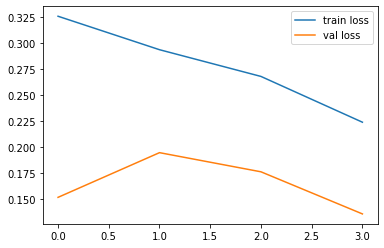

In [50]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()

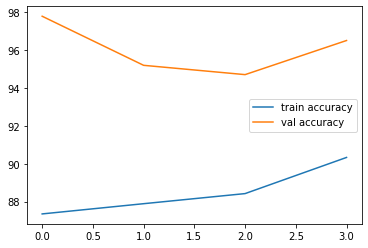

In [51]:
plt.plot(train_accuracy, label='train accuracy')
plt.plot(val_accuracy, label='val accuracy')
plt.legend()
plt.show()

In [52]:
n_correct_train = 0.
n_total_train = 0.
train_predictions_all = []
train_predictions_all_value = []
#train_predictions_all_sm = []
train_targets_all = []
#train_targets_all_sm = []

for inputs, targets in train_loader:
    
    train_targets_np = targets.numpy()
    train_targets_all.append(train_targets_np)
    
    inputs, targets = inputs.to(device), targets.to(device)
    train_outputs = model(inputs)
    train_outputs = torch.sigmoid(train_outputs)
    
    #sm_train = torch.nn.Softmax()
    #train_outputs_sm = sm_train(train_outputs)
    _, train_predictions = torch.max(train_outputs, 1)
    train_predictions_np = train_predictions.cpu().numpy()
    train_predictions_all.append(train_predictions_np)
    
    train_predictions_np_value = train_outputs.cpu().detach().numpy()
    train_predictions_all_value.append(train_predictions_np_value)
    
    #train_predictions_np_sm = train_outputs_sm.cpu().detach().numpy()
    #train_predictions_all_sm.append(train_predictions_np_sm)

train_predictions_np_out = []
train_predictions_np_out_value = []
train_targets_np_out = []
#train_predictions_np_out_sm = []
#train_targets_np_out_sm = []

train_count = len(train_predictions_all)

for z in range(train_count):
    
    for a in train_predictions_all[z]:
        train_predictions_np_out.append(a)

    for a in train_predictions_all_value[z]:
        train_predictions_np_out_value.append(a)
        
    for a in train_targets_all[z]:
        train_targets_np_out.append(a)    
'''
for z in range(train_count):
    
    for a in train_predictions_all_sm[z]:
        train_predictions_np_out_sm.append(a)
        
    for a in train_targets_all_sm[z]:
        train_targets_np_out_sm.append(a)  
'''        
train_predictions_np_out = np.asarray(train_predictions_np_out)
train_predictions_np_out_value = np.asarray(train_predictions_np_out_value)
train_targets_np_out = np.asarray(train_targets_np_out)

#train_predictions_np_out_sm = np.asarray(train_predictions_np_out_sm)
#train_targets_np_out_sm = np.asarray(train_targets_np_out_sm)

train_count = len(train_predictions_np_out)

for z in range(train_count):
    if train_predictions_np_out[z] == np.int(train_targets_np_out[z]):
        n_correct_train += 1

train_acc = n_correct_train / train_count
# --------------------------------------------------------------------------------        
n_correct_val = 0.
n_total_val = 0.
val_predictions_all = []
val_predictions_all_value = []
#val_predictions_all_sm = []
val_targets_all = []
                    
for inputs, targets in val_loader:
    
    val_targets_np = targets.numpy()
    val_targets_all.append(val_targets_np)
    
    inputs, targets = inputs.to(device), targets.to(device)
    val_outputs = model(inputs)
    val_outputs = torch.sigmoid(val_outputs)
    #sm_val = torch.nn.Softmax()
    #val_outputs_sm = sm_val(val_outputs)
    _, val_predictions = torch.max(val_outputs, 1)
    val_predictions_np = val_predictions.cpu().numpy()
    val_predictions_all.append(val_predictions_np)

    val_predictions_np_value = val_outputs.cpu().detach().numpy()
    val_predictions_all_value.append(val_predictions_np_value)
    #val_predictions_np_sm = val_outputs_sm.cpu().detach().numpy()
    #val_predictions_all_sm.append(val_predictions_np_sm)
 
val_predictions_np_out = []
val_predictions_np_out_value = []
val_targets_np_out = []
val_count = len(val_predictions_all)

for z in range(val_count):
    
    for a in val_predictions_all[z]:
        val_predictions_np_out.append(a)

    for a in val_predictions_all_value[z]:
        val_predictions_np_out_value.append(a)
        
    for a in val_targets_all[z]:
        val_targets_np_out.append(a)

val_predictions_np_out = np.asarray(val_predictions_np_out)
train_predictions_np_out_value = np.asarray(train_predictions_np_out_value)
val_targets_np_out = np.asarray(val_targets_np_out)

val_count = len(val_predictions_np_out)

for z in range(val_count):
    if val_predictions_np_out[z] == np.int(val_targets_np_out[z]):
        n_correct_val += 1

val_acc = n_correct_val / val_count
      
print(f"Train acc: {train_acc:.4f}, Val acc: {val_acc:.4f}")

Train acc: 0.8745, Val acc: 0.9823


In [53]:
fpr_train, tpr_train, _ = roc_curve(train_targets_np_out, train_predictions_np_out_value)
fpr_val, tpr_val, _ = roc_curve(val_targets_np_out, val_predictions_np_out_value)

In [54]:
auc_pred_train = auc(fpr_train, tpr_train) 
auc_pred_val = auc(fpr_val, tpr_val) 

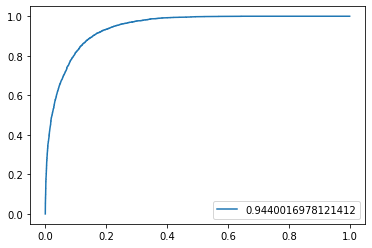

In [55]:
plt.plot(fpr_train, tpr_train, label = auc_pred_train)
plt.legend()

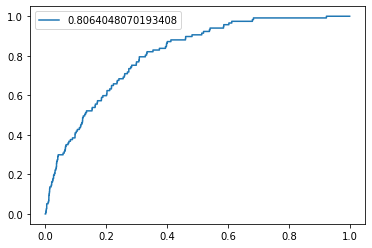

In [56]:
plt.plot(fpr_val, tpr_val, label = auc_pred_val)
plt.legend()

In [ ]:
from sklearn.metrics import classification_report
import itertools

In [ ]:
print(classification_report(train_predictions_np_out, train_targets_np_out))

In [ ]:
print(classification_report(val_predictions_np_out, val_targets_np_out))

In [ ]:
max(val_targets_np_out)

## Start of test data

In [ ]:
csv_test_file = pd.read_csv('/home/malmason/datasets/siim-isic-melanoma-classification/test.csv')

In [ ]:
img_test_folder = '/home/malmason/datasets/siim-isic-melanoma-classification/ycbcr/norm/test/'

In [ ]:
X_test_img = csv_test_file['image_name']

In [ ]:
csv_test_file["anatom_site_general_challenge"].fillna("Unknown", inplace = True)
csv_test_file["sex"].fillna("Unknown", inplace = True) 

In [ ]:
csv_test_file.sex = csv_test_file.sex.map(sex_cat).astype(float)
csv_test_file.age_approx = csv_test_file.age_approx.map(age_cat).astype(float)
csv_test_file.anatom_site_general_challenge = csv_test_file.anatom_site_general_challenge.map(localization_cat).astype(float)

In [ ]:
X_test_data = csv_train_file.drop(['image_name', 'patient_id'], axis=1)

In [ ]:
X_test_img = csv_test_file['image_name']

In [ ]:
csv_test_file.head()

In [ ]:
X_test_image = []
for image_get in X_test_img:
    img_test = cv2.imread(img_test_folder + '{}.jpg'.format(image_get))
    X_test_image.append(img_test)

In [ ]:
X_test_image = np.array(X_test_image.astype(np.float32))

In [ ]:
X_test_image = X_test_image / 255